In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from keras.datasets import mnist, fashion_mnist
import tensorflow.keras as kb
from tensorflow.keras import backend
import tensorflow as tf

# Advanced CNN Techniques
- Data Augmentation
- Residual Connections
- Depthwise Separable Connections
- Visualizing Layer Activations
- Visualizing Filters
- Grad CAM


## Data Augmentation

Data Augmentation is a method specific to CNNs that allows us to regularize our Network by showing the network the same image over and over with *slight* changes to things like:

- rotation
- crop
- zoom
- translation

This is also helpful because we want our CNN to be able to recognize images even when they're shifted a little bit. 

Keras has a bunch of [`Random_*` layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/) which perform data augmentation for us. We can add a stack of them to a CNN before the first layer in order to perform data augmentation. 

In [2]:
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = kb.utils.to_categorical(y_train, 10)
y_test = kb.utils.to_categorical(y_test, 10)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
model = kb.Sequential([
    kb.layers.InputLayer(input_shape =(28,28,1)),
    kb.layers.RandomFlip(),
    kb.layers.RandomZoom(0.2),
    kb.layers.RandomRotation(0.1),
    kb.layers.Conv2D(32, (3, 3), activation='relu', padding = "same"),
    kb.layers.Conv2D(64, (3, 3), activation='relu', padding = "same"),
    kb.layers.MaxPooling2D((2, 2)),
    kb.layers.Flatten(),
    kb.layers.Dense(100, activation='relu'),
    kb.layers.Dense(10, activation='softmax'),
])

model.summary()

2023-03-08 19:00:45.919551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 28, 28, 1)         0         
                                                                 
 random_zoom (RandomZoom)    (None, 28, 28, 1)         0         
                                                                 
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                      

In [4]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, epochs=1, validation_data = (x_test, y_test))

1875/1875 [==============================] - 71s 37ms/step - loss: 0.7326 - accuracy: 0.7290 - val_loss: 0.5581 - val_accuracy: 0.7942


## Residual Connections

Residual Connections create two paths for data to flow through:

1. the traditional path which pushes the input image through the convolutional + pooling layers
2. a non-destructive path that passes the image through unchanged (though we may reduce the size to match the output of the other path)

These two paths are then added together before passing the output through to the next block of conv + pool layers. 

Because we're no longer using a simple, sequential stack of layers, we have to use the Functional API to define this architechture rather than `Sequential()`. 😭

In [5]:
input = kb.Input(shape = (28,28,1))
x = kb.layers.Conv2D(32, (3,3), activation = "relu")(input)
residual = x
x = kb.layers.Conv2D(64, (3,3), padding = "same", activation = "relu")(x)
residual = kb.layers.Conv2D(64,(1,1))(residual)
x = kb.layers.add([x,residual])
x = kb.layers.MaxPooling2D((2, 2))(x)
x = kb.layers.Flatten()(x)
x = kb.layers.Dense(100, activation='relu')(x)
output = kb.layers.Dense(10, activation='softmax')(x)

model = kb.Model(inputs = input, outputs = output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 26, 26, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 26, 26, 64)   18496       ['conv2d_2[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 26, 26, 64)   2112        ['conv2d_2[0][0]']               
                                                                                              

In [6]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, epochs=1, validation_data = (x_test, y_test))

1875/1875 [==============================] - 66s 35ms/step - loss: 0.3487 - accuracy: 0.8759 - val_loss: 0.2613 - val_accuracy: 0.9020


## Depthwise Separable Convolutions

[Depthwise Separable Convolutions](https://keras.io/api/layers/convolution_layers/separable_convolution2d/) are a way to reduce the computational cost of performing a convolution. DSC's apply a filter to each channel in an input image *separately* and then convolve those outputs together. This does assume that the different channels in the input are highly independent, but that's often true so it typically won't reduce the performance of your model unless that assumption is violated.

Luckily, `SeparableConv2D()` is a drop-in replacement for `Conv2D()`.

In [7]:
model = kb.Sequential([
    kb.layers.InputLayer(input_shape =(28,28,1)),
    kb.layers.SeparableConv2D(32, (3, 3), activation='relu', padding = "same"),
    kb.layers.SeparableConv2D(64, (3, 3), activation='relu', padding = "same"),
    kb.layers.MaxPooling2D((2, 2)),
    kb.layers.Flatten(),
    kb.layers.Dense(100, activation='relu'),
    kb.layers.Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 28, 28, 32)       73        
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 28, 28, 64)       2400      
 leConv2D)                                                       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_4 (Dense)             (None, 100)               1254500   
                                                      

In [8]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, epochs=1, validation_data = (x_test, y_test))

1875/1875 [==============================] - 52s 27ms/step - loss: 0.4368 - accuracy: 0.8426 - val_loss: 0.3605 - val_accuracy: 0.8738


## Visualizations

### Visualizing Layer Activations

In [9]:
# model = kb.Sequential([
#     kb.layers.InputLayer(input_shape =(28,28,1)),
#     kb.layers.Conv2D(32, (3, 3), activation='relu', padding = "same"),
#     kb.layers.Conv2D(64, (3, 3), activation='relu', padding = "same"),
#     kb.layers.MaxPooling2D((2, 2)),
#     kb.layers.Flatten(),
#     kb.layers.Dense(10, activation='softmax'),
# ])

# model.summary()



In [10]:
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# model.fit(x_train, y_train, epochs=25, validation_data = (x_test, y_test))
# model.save("11_smallConvNet")

model = kb.models.load_model("11_smallConvNet")

In [11]:
layer_out = []
layer_name = []

for layer in model.layers:
    if isinstance(layer, (kb.layers.Conv2D, kb.layers.MaxPooling2D)):
        layer_out.append(layer.output)
        layer_name.append(layer.name)

layer_activations = kb.Model(inputs = model.input, outputs = layer_out)

layer_activations.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [12]:
img = kb.utils.img_to_array(x_train[0])
img = np.expand_dims(img, axis = 0)
activations = layer_activations.predict(img)


1/1 [==============================] - 0s 65ms/step


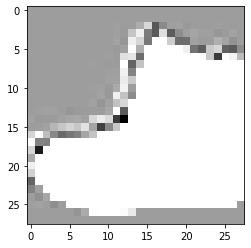

In [13]:
import matplotlib.pyplot as plt

# which layer and channel you want to look at
layer = 0
channel = 3

# grab layer and channel and plot
layer_act = activations[layer]
plt.imshow(layer_act[0,:,:,channel], cmap = "Greys")

### Visualizing Filters

We can also visualize the filters learned by your CNN by using *gradient **ascent*** to find an image that *maximally* activates the filter as it's slid across an input. 

We start with a blank image and then make iterative changes that maximize the filter output more and more at each step.


First, let's pull the names of the Convolutional Layers in our Model so we know what they're called.

In [14]:
layer_name2 = []

for layer in model.layers:
    if isinstance(layer, (kb.layers.Conv2D)):
        layer_name2.append(layer.name)

layer_name2

['conv2d_4', 'conv2d_5']

Then, we'll pull the layer from the model and create a NEW model that returns the output of that layer.

In [15]:
layer_name = "conv2d_5"

layer = model.get_layer(layer_name)

feature_extractor = kb.Model(inputs = model.input, outputs = layer.output)

Then we'll define some functions to do the gradient ascent (modified from Chapter 9 in your book), but adapt it to work with a 1D image.

In [16]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, 28, 28, 1))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[2:-2, 2:-2, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return(image)

Finally, let's use those functions to visualze the filters.

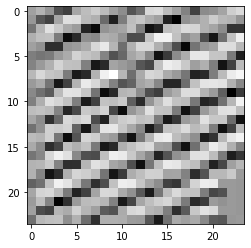

In [17]:
filter_no = 20
loss, img = visualize_filter(filter_no)

plt.imshow(img.reshape((24,24)), cmap = "Greys")

### Visualizing Class Activation Heatmaps

Class activation heatmaps (CAM) are really helpful in showing us what in an image is causing the model to make it's classification. 

We do this by combining two things:

- how much our image activates the various features learned by our last convolutional layer
- how important those features are to classifying an image as a certain category



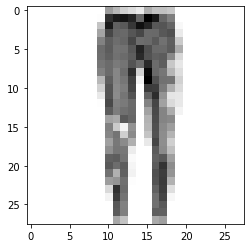

In [18]:
img_size = (28, 28)
last_conv_layer_name = "conv2d_5"

img = np.expand_dims(x_train[78], 0)
img.shape

plt.imshow(img.reshape((28,28)), cmap = "Greys")


In [19]:

def get_img_array(img, size):
    # `array` is a float32 Numpy array of shape (28, 28, 1)
    array = kb.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = kb.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output,
         model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 [==============================] - 0s 45ms/step


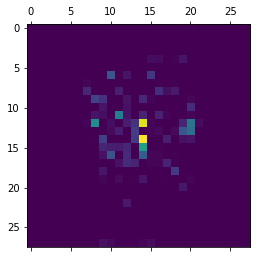

In [20]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

## Upsampling After Convolution

In the lecture I *briefly* mentioned that for image segmentation, we want to produce a mask that is the *same size* as our input image, because each pixel of the mask tells us what category each pixel in the image should be. 

However we've been learning that CNNs typically reduce the size of the input image (or *downsample*) one or more times with Pooling layers. So if we want to get our input to its original shape, we need to *upsample* the image.

We can do this with `Conv2DTranspose()` layers (learn more [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)). 


`Conv2DTranspose()` layers *essentially* learn to undo `Conv2D()` layers. For example, if you have a `(100,100,64)` input and put it through a `Conv2D(128, (3,3), padding = "same", stride = 2)` layer, your output will be `(50,50,128)`. To make that `(100,100,64)` again we'd need to put it through a `Conv2DTranspose(64, (3,3), padding = "same", stride = 2)` layer. 

<img src="https://drive.google.com/uc?export=view&id=1jPHABc6LNHIBUFppsUXfB-Lm6TtH4AF-" alt="Q" width = "400"/>
<img src="https://drive.google.com/uc?export=view&id=1Lbs1XzStTqkCOVxKK_FsWQzAaPZqktGV" alt="Q" width = "400"/>



(Images from: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d)


In [ ]:
# example from your book Deep Learning with Python by Chollet
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = kb.layers.Rescaling(1./255)(inputs)

    x = kb.layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = kb.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = kb.layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = kb.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = kb.layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = kb.layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = kb.layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = kb.layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = kb.layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = kb.layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = kb.layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = kb.layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = kb.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = kb..Model(inputs, outputs)
    return model

# In Class

Read Through and play around with [this Grad-CAM example](https://keras.io/examples/vision/grad_cam/) from Keras' website (this is the code used to generate the Grad CAM images in your book). You can click "View in Colab" to play with it in Google Cola. These look a LOT better than the ones we just made because the images are larger and full color images instead of gray-scale.